In [1]:
pwd

'C:\\Users\\Admin'

In [17]:
import numpy as np
import pandas as pd

In [18]:
import os
for dirname,_,flesnames in os.walk('Kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

In [19]:
pd.set_option('display.max_columns',None)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report

In [21]:
mdf=pd.read_csv('matches.csv')
mdf.shape

(1095, 20)

In [22]:
mdf_clone=mdf.copy()

In [23]:
pd.concat([mdf_clone['team1'], mdf_clone['team2']]).unique()

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Rajasthan Royals', 'Deccan Chargers', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

In [24]:
team1_win_count = len(mdf.loc[mdf['team1'] == mdf['winner']])
team2_win_count = len(mdf.loc[mdf['team2'] == mdf['winner']])
team1_win_count, team2_win_count

(555, 535)

In [25]:
mdf['dayofyear'] = pd.to_datetime(mdf['date']).dt.dayofyear
mdf['dayofweek'] = pd.to_datetime(mdf['date']).dt.dayofweek
mdf['season'] = pd.to_datetime(mdf['date']).dt.year

C:\Users\Admin\AppData\Local\Temp\ipykernel_2880\915891701.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  mdf['dayofyear'] = pd.to_datetime(mdf['date']).dt.dayofyear
C:\Users\Admin\AppData\Local\Temp\ipykernel_2880\915891701.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  mdf['dayofweek'] = pd.to_datetime(mdf['date']).dt.dayofweek
C:\Users\Admin\AppData\Local\Temp\ipykernel_2880\915891701.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  mdf['season'] = pd.to_datetime(mdf['date']).dt.year


In [26]:
mdf = mdf.drop(columns=['date'])

In [27]:
team_city_map = {
    'Sunrisers Hyderabad': 'Hyderabad',
    'Deccan Chargers': 'Hyderabad',
    'Mumbai Indians': 'Mumbai',
    'Gujarat Lions': 'Gujarat',
    'Gujarat Titans': 'Gujarat',
    'Rising Pune Supergiants': 'Pune',
    'Rising Pune Supergiant': 'Pune',
    'Pune Warriors': 'Pune',
    'Royal Challengers Bangalore': 'Bangalore',
    'Royal Challengers Bengaluru': 'Bangalore',
    'Kolkata Knight Riders': 'Kolkata',
    'Delhi Daredevils': 'Delhi',
    'Delhi Capitals': 'Delhi',
    'Kings XI Punjab': 'Punjab',
    'Punjab Kings': 'Punjab',
    'Chennai Super Kings': 'Chennai',
    'Rajasthan Royals': 'Rajasthan',
    'Kochi Tuskers Kerala': 'Kochi',
    'Lucknow Super Giants': 'Lucknow'
}

def team_to_city(df, feature):
    df[feature] = df[feature].map(team_city_map)
    return df

def map_team_city(df):
    mdf = df.copy()
    for feature in ['team1', 'team2', 'toss_winner', 'winner']:
        if feature in mdf.columns:
            mdf = team_to_city(mdf, feature)
    return mdf

# Apply the function to the DataFrame
mdf = map_team_city(mdf)

In [28]:
mdf['team1_home'] = False
mdf['team2_home'] = False

mdf.loc[mdf['city'] == mdf['team1'], 'team1_home'] = True
mdf.loc[mdf['city'] == mdf['team2'], 'team2_home'] = True

In [29]:
mdf = mdf.drop(mdf.loc[mdf['result'] == 'no result'].index, axis=0)

In [30]:
mdf.head()

,id,season,city,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home
0,335982,2008,Bangalore,League,BB McCullum,M Chinnaswamy Stadium,Bangalore,Kolkata,Bangalore,field,Kolkata,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,109,4,True,False
1,335983,2008,Chandigarh,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Punjab,Chennai,Chennai,bat,Chennai,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri,110,5,False,False
2,335984,2008,Delhi,League,MF Maharoof,Feroz Shah Kotla,Delhi,Rajasthan,Rajasthan,bat,Delhi,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar,110,5,True,False
3,335985,2008,Mumbai,League,MV Boucher,Wankhede Stadium,Mumbai,Bangalore,Mumbai,bat,Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper,111,6,True,False
4,335986,2008,Kolkata,League,DJ Hussey,Eden Gardens,Kolkata,Hyderabad,Hyderabad,bat,Kolkata,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan,111,6,True,False


In [31]:
mdf['target_overs'].unique()

array([20. , 16. ,  8. , 18. ,  6. ,  9.2, 17. , 10. , 13. , 12. ,  5. ,
       11. ,  9. , 14. , 15. ])

In [32]:
mdf.isna().sum()

id                    0
season                0
city                 51
match_type            0
player_of_match       0
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                0
result                0
result_margin        14
target_runs           0
target_overs          0
super_over            0
method             1069
umpire1               0
umpire2               0
dayofyear             0
dayofweek             0
team1_home            0
team2_home            0
dtype: int64

In [33]:
mdf = mdf.drop(columns=['method'])

In [34]:
mdf = mdf.dropna()

In [35]:
import math
total_teams_score = {}
total_teams_balls = {}
match_tosswinner_count = {}
match_innings2_team_count = {}
avg_teams_score = {}
avg_teams_balls_left = {}

def team_avg_scores(df):
    df = df.copy()
    for index, row in df.iterrows():
        toss_winner = row['toss_winner']
        target_runs = row['target_runs']
        target_overs = row['target_overs']
        innings2_team = row['team2'] if row['team1'] == row['toss_winner'] else row['team1']
        
        if toss_winner not in total_teams_score:
            total_teams_score[toss_winner] = 0
        if toss_winner not in match_tosswinner_count:
            match_tosswinner_count[toss_winner] = 0
        if innings2_team not in total_teams_balls:
            total_teams_balls[innings2_team] = 0
        if innings2_team not in match_innings2_team_count:
            match_innings2_team_count[innings2_team] = 0

        total_teams_score[toss_winner] += target_runs
        num_balls = (math.floor(target_overs) - 1) * 6 + (target_overs - math.floor(target_overs)) * 10
        total_teams_balls[innings2_team] += (120 - num_balls)
        # 20 overs is 120 balls. We calculate how many balls they were left with.
        match_tosswinner_count[toss_winner] += 1
        match_innings2_team_count[innings2_team] += 1
    
    # Calculate the average scores and overs
    for team in total_teams_score.keys():
        avg_teams_score[team] = total_teams_score[team] / match_tosswinner_count[team]
    for team in total_teams_balls.keys():
        avg_teams_balls_left[team] = total_teams_balls[team] / match_innings2_team_count[team]
    
    # Add new features to the DataFrame
    df['team1_avg_score'] = df['team1'].apply(lambda x: avg_teams_score.get(x, 0))
    df['team2_avg_score'] = df['team2'].apply(lambda x: avg_teams_score.get(x, 0))
    df['team1_avg_balls_left'] = df['team1'].apply(lambda x: avg_teams_balls_left.get(x, 0))
    df['team2_avg_balls_left'] = df['team2'].apply(lambda x: avg_teams_balls_left.get(x, 0))
    
    return df

# Apply the function to the DataFrame
mdf = team_avg_scores(mdf)

In [36]:
mdf.head()

,id,season,city,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left
0,335982,2008,Bangalore,League,BB McCullum,M Chinnaswamy Stadium,Bangalore,Kolkata,Bangalore,field,Kolkata,runs,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,109,4,True,False,168.779817,159.462185,7.795276,9.000000
1,335983,2008,Chandigarh,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Punjab,Chennai,Chennai,bat,Chennai,runs,33.0,241.0,20.0,N,MR Benson,SL Shastri,110,5,False,False,170.611650,164.191304,8.468750,6.833333
2,335984,2008,Delhi,League,MF Maharoof,Feroz Shah Kotla,Delhi,Rajasthan,Rajasthan,bat,Delhi,wickets,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,110,5,True,False,164.959016,165.216216,7.761468,6.893617
3,335985,2008,Mumbai,League,MV Boucher,Wankhede Stadium,Mumbai,Bangalore,Mumbai,bat,Bangalore,wickets,5.0,166.0,20.0,N,SJ Davis,DJ Harper,111,6,True,False,169.902985,168.779817,6.000000,7.795276
4,335986,2008,Kolkata,League,DJ Hussey,Eden Gardens,Kolkata,Hyderabad,Hyderabad,bat,Kolkata,wickets,5.0,111.0,20.0,N,BF Bowden,K Hariharan,111,6,True,False,159.462185,160.907563,9.000000,7.563025


In [37]:
total_teams_balls

{'Kolkata': 1080.0,
 'Punjab': 1084.0,
 'Delhi': 846.0,
 'Bangalore': 990.0,
 'Rajasthan': 648.0,
 'Chennai': 738.0,
 'Hyderabad': 900.0,
 'Mumbai': 678.0,
 'Pune': 252.0,
 'Kochi': 36.0,
 'Gujarat': 258.0,
 'Lucknow': 144.0}

In [38]:
mdf.head()

,id,season,city,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left
0,335982,2008,Bangalore,League,BB McCullum,M Chinnaswamy Stadium,Bangalore,Kolkata,Bangalore,field,Kolkata,runs,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,109,4,True,False,168.779817,159.462185,7.795276,9.000000
1,335983,2008,Chandigarh,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Punjab,Chennai,Chennai,bat,Chennai,runs,33.0,241.0,20.0,N,MR Benson,SL Shastri,110,5,False,False,170.611650,164.191304,8.468750,6.833333
2,335984,2008,Delhi,League,MF Maharoof,Feroz Shah Kotla,Delhi,Rajasthan,Rajasthan,bat,Delhi,wickets,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,110,5,True,False,164.959016,165.216216,7.761468,6.893617
3,335985,2008,Mumbai,League,MV Boucher,Wankhede Stadium,Mumbai,Bangalore,Mumbai,bat,Bangalore,wickets,5.0,166.0,20.0,N,SJ Davis,DJ Harper,111,6,True,False,169.902985,168.779817,6.000000,7.795276
4,335986,2008,Kolkata,League,DJ Hussey,Eden Gardens,Kolkata,Hyderabad,Hyderabad,bat,Kolkata,wickets,5.0,111.0,20.0,N,BF Bowden,K Hariharan,111,6,True,False,159.462185,160.907563,9.000000,7.563025


In [39]:
mdf['city'] = mdf['city'].fillna('Mumbai')
mdf['umpire1'] = mdf['umpire1'].fillna('HDPK Dharmasena')
mdf['umpire2'] = mdf['umpire2'].fillna('S Ravi')

In [40]:
mdf = pd.get_dummies(mdf, columns = ['toss_decision'], drop_first=True)

In [41]:
mdf = mdf.drop(columns=['id', 'result'])

In [42]:
mdf.head()

,season,city,match_type,player_of_match,venue,team1,team2,toss_winner,winner,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left,toss_decision_field
0,2008,Bangalore,League,BB McCullum,M Chinnaswamy Stadium,Bangalore,Kolkata,Bangalore,Kolkata,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,109,4,True,False,168.779817,159.462185,7.795276,9.000000,1
1,2008,Chandigarh,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Punjab,Chennai,Chennai,Chennai,33.0,241.0,20.0,N,MR Benson,SL Shastri,110,5,False,False,170.611650,164.191304,8.468750,6.833333,0
2,2008,Delhi,League,MF Maharoof,Feroz Shah Kotla,Delhi,Rajasthan,Rajasthan,Delhi,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,110,5,True,False,164.959016,165.216216,7.761468,6.893617,0
3,2008,Mumbai,League,MV Boucher,Wankhede Stadium,Mumbai,Bangalore,Mumbai,Bangalore,5.0,166.0,20.0,N,SJ Davis,DJ Harper,111,6,True,False,169.902985,168.779817,6.000000,7.795276,0
4,2008,Kolkata,League,DJ Hussey,Eden Gardens,Kolkata,Hyderabad,Hyderabad,Kolkata,5.0,111.0,20.0,N,BF Bowden,K Hariharan,111,6,True,False,159.462185,160.907563,9.000000,7.563025,0


In [43]:
mdf = mdf.drop(columns=['player_of_match'])

In [44]:
matches_won = dict(mdf['winner'].value_counts())

In [45]:
team1_played = dict(mdf['team1'].value_counts())
team2_played = dict(mdf['team2'].value_counts())

matches_played = {}
for team, count in team1_played.items():
    if team not in matches_played.keys():
        matches_played[team] = 0
    matches_played[team] += count

for team, count in team2_played.items():
    if team not in matches_played.keys():
        matches_played[team] = 0
    matches_played[team] += count

In [46]:
win_ratio = {}
for team, count in matches_played.items():
    win_ratio[team] = matches_won[team] / count
    
win_ratio

{'Bangalore': 0.4872881355932203,
 'Chennai': 0.5874439461883408,
 'Hyderabad': 0.453781512605042,
 'Punjab': 0.43722943722943725,
 'Mumbai': 0.5546558704453441,
 'Delhi': 0.45021645021645024,
 'Kolkata': 0.5313807531380753,
 'Rajasthan': 0.5219512195121951,
 'Pune': 0.36,
 'Gujarat': 0.5540540540540541,
 'Lucknow': 0.5581395348837209,
 'Kochi': 0.42857142857142855}

In [47]:
mdf.head()

,season,city,match_type,venue,team1,team2,toss_winner,winner,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left,toss_decision_field
0,2008,Bangalore,League,M Chinnaswamy Stadium,Bangalore,Kolkata,Bangalore,Kolkata,140.0,223.0,20.0,N,Asad Rauf,RE Koertzen,109,4,True,False,168.779817,159.462185,7.795276,9.000000,1
1,2008,Chandigarh,League,"Punjab Cricket Association Stadium, Mohali",Punjab,Chennai,Chennai,Chennai,33.0,241.0,20.0,N,MR Benson,SL Shastri,110,5,False,False,170.611650,164.191304,8.468750,6.833333,0
2,2008,Delhi,League,Feroz Shah Kotla,Delhi,Rajasthan,Rajasthan,Delhi,9.0,130.0,20.0,N,Aleem Dar,GA Pratapkumar,110,5,True,False,164.959016,165.216216,7.761468,6.893617,0
3,2008,Mumbai,League,Wankhede Stadium,Mumbai,Bangalore,Mumbai,Bangalore,5.0,166.0,20.0,N,SJ Davis,DJ Harper,111,6,True,False,169.902985,168.779817,6.000000,7.795276,0
4,2008,Kolkata,League,Eden Gardens,Kolkata,Hyderabad,Hyderabad,Kolkata,5.0,111.0,20.0,N,BF Bowden,K Hariharan,111,6,True,False,159.462185,160.907563,9.000000,7.563025,0


In [48]:
mdf['team1_win_ratio'] = mdf['team1'].map(win_ratio)
mdf['team2_win_ratio'] = mdf['team2'].map(win_ratio)

In [49]:
team_le = LabelEncoder()
team_name_features = pd.concat([mdf['city'], mdf['team1'], mdf['team2'], mdf['winner'], mdf['toss_winner']]).unique()
team_le.fit(team_name_features)

mdf['city'] = team_le.transform(mdf['city'])
mdf['winner'] = team_le.transform(mdf['winner'])
mdf['team1'] = team_le.transform(mdf['team1'])
mdf['team2'] = team_le.transform(mdf['team2'])
mdf['toss_winner'] = team_le.transform(mdf['toss_winner'])

In [50]:
le = LabelEncoder() # Use a different instance of the label encoder for the other features.

features = ['venue', 'umpire1', 'umpire2']
venue_le = LabelEncoder()
umpire_le = LabelEncoder()
umpire_le.fit(pd.concat([mdf['umpire1'], mdf['umpire2']]).unique())
mdf['venue'] = venue_le.fit_transform(mdf['venue'])
mdf['umpire1'] = umpire_le.transform(mdf['umpire1'])
mdf['umpire2'] = umpire_le.transform(mdf['umpire2'])


mdf.head()

,season,city,match_type,venue,team1,team2,toss_winner,winner,result_margin,target_runs,target_overs,super_over,umpire1,umpire2,dayofyear,dayofweek,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left,toss_decision_field,team1_win_ratio,team2_win_ratio
0,2008,2,League,23,2,24,2,24,140.0,223.0,20.0,N,10,48,109,4,True,False,168.779817,159.462185,7.795276,9.000000,1,0.487288,0.531381
1,2008,7,League,40,32,8,8,8,33.0,241.0,20.0,N,37,60,110,5,False,False,170.611650,164.191304,8.468750,6.833333,0,0.437229,0.587444
2,2008,10,League,16,10,34,34,10,9.0,130.0,20.0,N,9,20,110,5,True,False,164.959016,165.216216,7.761468,6.893617,0,0.450216,0.521951
3,2008,27,League,55,27,2,27,2,5.0,166.0,20.0,N,57,19,111,6,True,False,169.902985,168.779817,6.000000,7.795276,0,0.554656,0.487288
4,2008,24,League,14,24,17,17,24,5.0,111.0,20.0,N,11,31,111,6,True,False,159.462185,160.907563,9.000000,7.563025,0,0.531381,0.453782


In [51]:
mdf = mdf.drop(columns=['super_over'])

In [52]:
mdf.columns

Index(['season', 'city', 'match_type', 'venue', 'team1', 'team2',
       'toss_winner', 'winner', 'result_margin', 'target_runs', 'target_overs',
       'umpire1', 'umpire2', 'dayofyear', 'dayofweek', 'team1_home',
       'team2_home', 'team1_avg_score', 'team2_avg_score',
       'team1_avg_balls_left', 'team2_avg_balls_left', 'toss_decision_field',
       'team1_win_ratio', 'team2_win_ratio'],
      dtype='object')

In [53]:
mdf = mdf.reindex(columns=['season', 'dayofyear', 'dayofweek', 'venue', 'city', 
                           'team1', 'team2', 'team1_win_ratio', 'team2_win_ratio', 'team1_home', 'team2_home', 
                           'team1_avg_score', 'team2_avg_score', 'team1_avg_balls_left', 'team2_avg_balls_left',
                           'toss_winner',  'toss_decision_field',
                           'umpire1', 'umpire2', 
                           'winner'])

In [54]:
mdf['team1_wins'] = (mdf['winner'] == mdf['team1']).astype(int)
mdf = mdf.drop(columns=['winner'])
mdf.head()

,season,dayofyear,dayofweek,venue,city,team1,team2,team1_win_ratio,team2_win_ratio,team1_home,team2_home,team1_avg_score,team2_avg_score,team1_avg_balls_left,team2_avg_balls_left,toss_winner,toss_decision_field,umpire1,umpire2,team1_wins
0,2008,109,4,23,2,2,24,0.487288,0.531381,True,False,168.779817,159.462185,7.795276,9.000000,2,1,10,48,0
1,2008,110,5,40,7,32,8,0.437229,0.587444,False,False,170.611650,164.191304,8.468750,6.833333,8,0,37,60,0
2,2008,110,5,16,10,10,34,0.450216,0.521951,True,False,164.959016,165.216216,7.761468,6.893617,34,0,9,20,1
3,2008,111,6,55,27,27,2,0.554656,0.487288,True,False,169.902985,168.779817,6.000000,7.795276,27,0,57,19,0
4,2008,111,6,14,24,24,17,0.531381,0.453782,True,False,159.462185,160.907563,9.000000,7.563025,17,0,11,31,1


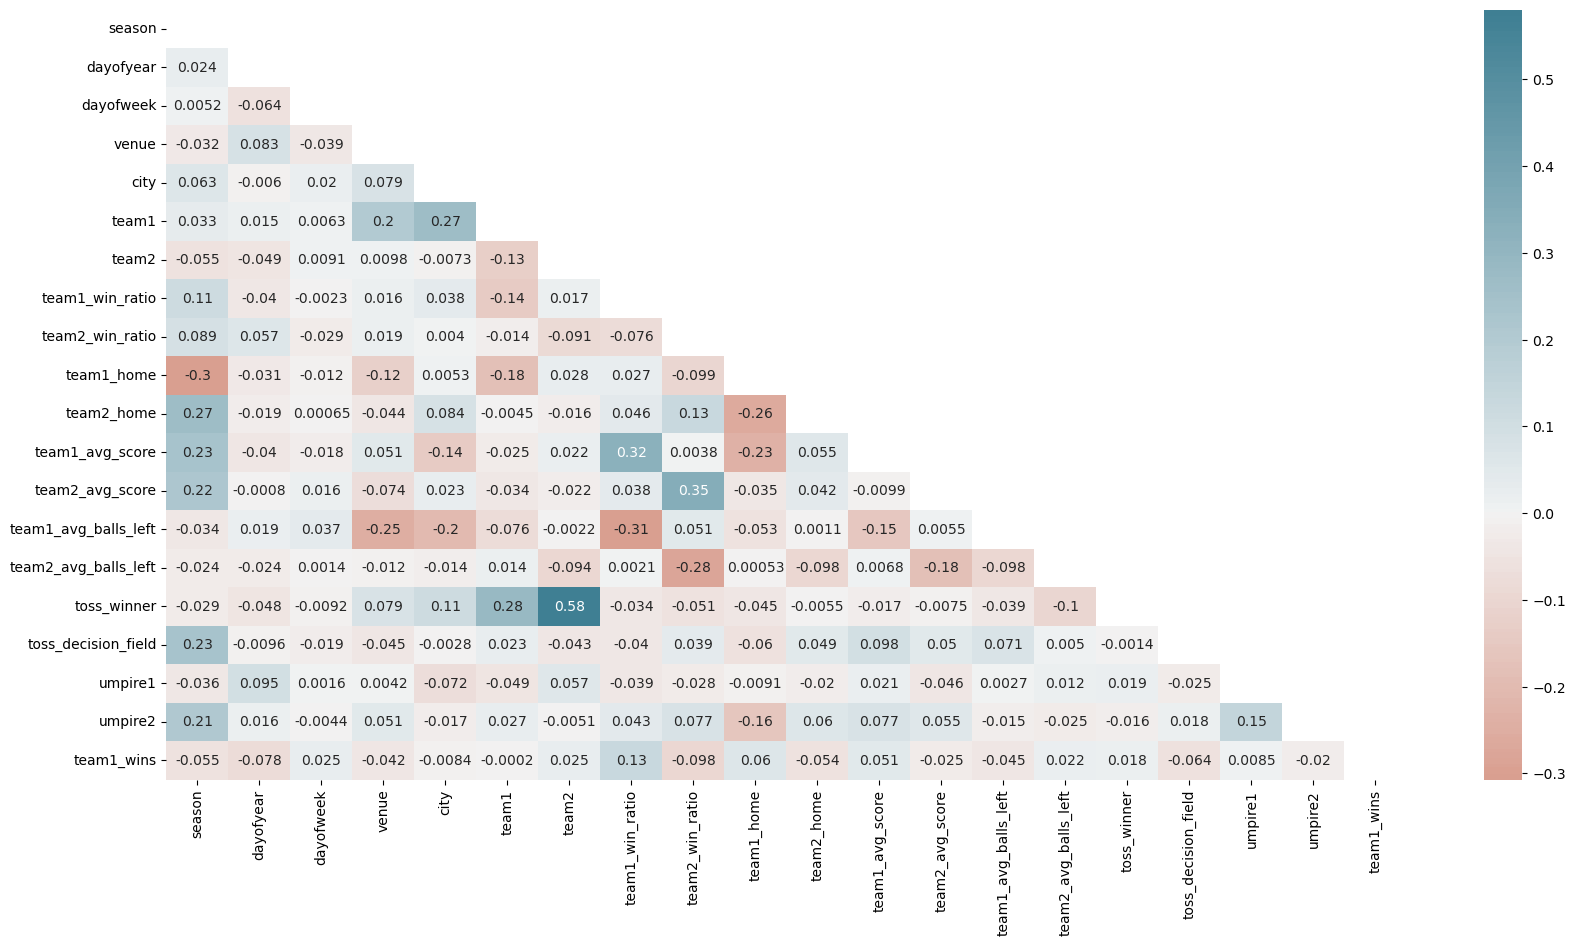

In [55]:
fig, ax = plt.subplots(figsize=(20, 10))
corr_matrix = mdf.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0)
plt.show()

In [56]:
X = mdf.drop(columns=['team1_wins'])
y = mdf['team1_wins']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
models_list = []
num_estimators_list =  [100, 200, 500, 1000, 1500, 2000]
max_depth_list = [3, 4, 5, 6, 7]
count = 0
for n_estimators in num_estimators_list:
    for max_depth in max_depth_list:
        model = ExtraTreesClassifier(max_depth=max_depth, n_estimators=n_estimators)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        ATrS = model.score(X_train, y_train)
        ATeS = model.score(X_test, y_test)
        models_list.append(pd.Series({"n_estimators": n_estimators, "max_depth": max_depth, "ATrS": ATrS, "ATeS": ATeS}))
        count += 1
        print(f"Finished: {count}/{len(num_estimators_list)*len(max_depth_list)}")
extra_models = pd.DataFrame(models_list)
extra_models.head(30)

Finished: 1/30
Finished: 2/30
Finished: 3/30
Finished: 4/30
Finished: 5/30
Finished: 6/30
Finished: 7/30
Finished: 8/30
Finished: 9/30
Finished: 10/30
Finished: 11/30
Finished: 12/30
Finished: 13/30
Finished: 14/30
Finished: 15/30
Finished: 16/30
Finished: 17/30
Finished: 18/30
Finished: 19/30
Finished: 20/30
Finished: 21/30
Finished: 22/30
Finished: 23/30
Finished: 24/30
Finished: 25/30
Finished: 26/30
Finished: 27/30
Finished: 28/30
Finished: 29/30
Finished: 30/30


,n_estimators,max_depth,ATrS,ATeS
0,100.0,3.0,0.633820,0.500000
1,100.0,4.0,0.676399,0.538835
2,100.0,5.0,0.742092,0.553398
3,100.0,6.0,0.830900,0.553398
4,100.0,7.0,0.878345,0.543689
5,200.0,3.0,0.620438,0.509709
6,200.0,4.0,0.676399,0.524272
7,200.0,5.0,0.749392,0.538835
8,200.0,6.0,0.813869,0.548544
9,200.0,7.0,0.889294,0.519417


In [59]:
model = ExtraTreesClassifier(n_estimators=500, max_depth=3)
model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=3, n_estimators=500)

In [60]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [61]:
print('ATrS:', model.score(X_train, y_train))
print('ATeS:', model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

ATrS: 0.6362530413625304
ATeS: 0.5145631067961165
              precision    recall  f1-score   support

           0       0.54      0.34      0.42       105
           1       0.50      0.69      0.58       101

    accuracy                           0.51       206
   macro avg       0.52      0.52      0.50       206
weighted avg       0.52      0.51      0.50       206



In [62]:
mdf_clone['venue'].unique()

array(['M Chinnaswamy Stadium',
       'Punjab Cricket Association Stadium, Mohali', 'Feroz Shah Kotla',
       'Wankhede Stadium', 'Eden Gardens', 'Sawai Mansingh Stadium',
       'Rajiv Gandhi International Stadium, Uppal',
       'MA Chidambaram Stadium, Chepauk', 'Dr DY Patil Sports Academy',
       'Newlands', "St George's Park", 'Kingsmead', 'SuperSport Park',
       'Buffalo Park', 'New Wanderers Stadium', 'De Beers Diamond Oval',
       'OUTsurance Oval', 'Brabourne Stadium',
       'Sardar Patel Stadium, Motera', 'Barabati Stadium',
       'Brabourne Stadium, Mumbai',
       'Vidarbha Cricket Association Stadium, Jamtha',
       'Himachal Pradesh Cricket Association Stadium', 'Nehru Stadium',
       'Holkar Cricket Stadium',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
       'Subrata Roy Sahara Stadium',
       'Maharashtra Cricket Association Stadium',
       'Shaheed Veer Narayan Singh International Stadium',
       'JSCA International Stadium Complex', 'Sh

In [63]:
avg_teams_score

{'Bangalore': 168.77981651376146,
 'Chennai': 164.19130434782608,
 'Rajasthan': 165.21621621621622,
 'Mumbai': 169.90298507462686,
 'Hyderabad': 160.9075630252101,
 'Punjab': 170.61165048543688,
 'Kolkata': 159.46218487394958,
 'Delhi': 164.95901639344262,
 'Kochi': 140.5,
 'Pune': 149.12121212121212,
 'Gujarat': 177.33333333333334,
 'Lucknow': 192.57894736842104}

In [64]:
def process_test_data(df):
    df = df.copy()
    
    df['season'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.year
    df['dayofyear'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.dayofyear
    df['dayofweek'] = pd.to_datetime(df['date'], format='%Y-%m-%d').dt.dayofweek
    df = df.drop(columns=['date'])
    
#     df = map_team_city(df)
    
    df['team1_home'] = False
    df['team2_home'] = False
    
    df.loc[df['city'] == df['team1'], 'team1_home'] = True
    df.loc[df['city'] == df['team2'], 'team2_home'] = True
    
    df['team1_win_ratio'] = df['team1'].map(win_ratio)
    df['team2_win_ratio'] = df['team2'].map(win_ratio)
    
    df['team1_avg_score'] = df['team1'].map(avg_teams_score)
    df['team2_avg_score'] = df['team2'].map(avg_teams_score)
    df['team1_avg_balls_left'] = df['team1'].map(avg_teams_balls_left)
    df['team2_avg_balls_left'] = df['team2'].map(avg_teams_balls_left)
    
    df['team1'] = team_le.transform(df['team1'])
    df['team2'] = team_le.transform(df['team2'])
    df['city'] = team_le.transform(df['city'])
    df['toss_winner'] = team_le.transform(df['toss_winner'])
    
    df['venue'] = venue_le.transform(df['venue'])
    df['umpire1'] = umpire_le.transform(df['umpire1'])
    df['umpire2'] = umpire_le.transform(df['umpire2'])
        
    df = df.reindex(columns=['season', 'dayofyear', 'dayofweek', 'venue', 'city', 
                           'team1', 'team2', 'team1_win_ratio', 'team2_win_ratio', 'team1_home', 'team2_home', 
                           'team1_avg_score', 'team2_avg_score', 'team1_avg_balls_left', 'team2_avg_balls_left',
                           'toss_winner',  'toss_decision_field',
                           'umpire1', 'umpire2'])
    
    return df

In [65]:
from IPython.display import display
import ipywidgets as widgets
import pandas as pd
from datetime import datetime

teams = win_ratio.keys()
venues = mdf_clone['venue'].unique()
umpires = pd.concat([mdf_clone['umpire1'], mdf_clone['umpire2']]).unique()

stadium_city_map = {
        'M Chinnaswamy Stadium': 'Bangalore',
        'M Chinnaswamy Stadium, Bengaluru': 'Bangalore',
        'Punjab Cricket Association Stadium, Mohali': 'Mohali',
        'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Mohali',
        'Feroz Shah Kotla': 'Delhi',
        'Arun Jaitley Stadium': 'Delhi',
        'Arun Jaitley Stadium, Delhi': 'Delhi',
        'Wankhede Stadium': 'Mumbai',
        'Wankhede Stadium, Mumbai': 'Mumbai',
        'Eden Gardens': 'Kolkata',
        'Eden Gardens, Kolkata': 'Kolkata',
        'Sawai Mansingh Stadium': 'Jaipur',
        'Sawai Mansingh Stadium, Jaipur': 'Jaipur',
        'Rajiv Gandhi International Stadium, Uppal': 'Hyderabad',
        'Rajiv Gandhi International Stadium': 'Hyderabad',
        'Rajiv Gandhi International Stadium, Uppal, Hyderabad': 'Hyderabad',
        'MA Chidambaram Stadium, Chepauk': 'Chennai',
        'MA Chidambaram Stadium': 'Chennai',
        'MA Chidambaram Stadium, Chepauk, Chennai': 'Chennai',
        'Dr DY Patil Sports Academy': 'Mumbai',
        'Dr DY Patil Sports Academy, Mumbai': 'Mumbai',
        'Newlands': 'Cape Town',
        "St George's Park": 'Port Elizabeth',
        'Kingsmead': 'Durban',
        'SuperSport Park': 'Centurion',
        'Buffalo Park': 'East London',
        'New Wanderers Stadium': 'Johannesburg',
        'De Beers Diamond Oval': 'Kimberley',
        'OUTsurance Oval': 'Bloemfontein',
        'Brabourne Stadium': 'Mumbai',
        'Brabourne Stadium, Mumbai': 'Mumbai',
        'Sardar Patel Stadium, Motera': 'Ahmedabad',
        'Barabati Stadium': 'Cuttack',
        'Vidarbha Cricket Association Stadium, Jamtha': 'Nagpur',
        'Himachal Pradesh Cricket Association Stadium': 'Dharamsala',
        'Himachal Pradesh Cricket Association Stadium, Dharamsala': 'Dharamsala',
        'Nehru Stadium': 'Kochi',
        'Holkar Cricket Stadium': 'Indore',
        'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': 'Visakhapatnam',
        'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam': 'Visakhapatnam',
        'Subrata Roy Sahara Stadium': 'Pune',
        'Maharashtra Cricket Association Stadium': 'Pune',
        'Maharashtra Cricket Association Stadium, Pune': 'Pune',
        'Shaheed Veer Narayan Singh International Stadium': 'Raipur',
        'JSCA International Stadium Complex': 'Ranchi',
        'Sheikh Zayed Stadium': 'Abu Dhabi',
        'Sharjah Cricket Stadium': 'Sharjah',
        'Dubai International Cricket Stadium': 'Dubai',
        'Saurashtra Cricket Association Stadium': 'Rajkot',
        'Green Park': 'Kanpur',
        'Narendra Modi Stadium, Ahmedabad': 'Ahmedabad',
        'Zayed Cricket Stadium, Abu Dhabi': 'Abu Dhabi',
        'Eden Gardens, Kolkata': 'Kolkata',
        'Punjab Cricket Association IS Bindra Stadium': 'Mohali',
        'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh': 'Mohali',
        'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow': 'Lucknow',
        'Barsapara Cricket Stadium, Guwahati': 'Guwahati',
        'Maharaja Yadavindra Singh International Cricket Stadium, Mullanpur': 'Mullanpur'
}

date = widgets.DatePicker(description='Select a date', disabled=False)
venue = widgets.Dropdown(options=venues, description='Venue:')
team1 = widgets.Dropdown(options=teams, description='Team 1:')
team2 = widgets.Dropdown(options=teams, description='Team 2:')
toss_winner = widgets.Dropdown(options=teams, description='Toss Winner:')
toss_decision_field = widgets.Checkbox(value=False, description='Toss winner chose fielding?')
umpire1 = widgets.Dropdown(options=umpires, description='Umpire 1:')
umpire2 = widgets.Dropdown(options=umpires, description='Umpire 2:')

prediction_result = widgets.Output()

def handle_prediction(btn):
    with prediction_result:
        prediction_result.clear_output()
        if team1.value == team2.value:
            print("Team1 and team2 cannot be the same!")
            return
        if umpire1.value == umpire2.value:
            print("One person can't be both umpires!")
            return
        
        test_data = {
            'date': date.value,
            'venue': venue.value,
            'city': stadium_city_map[venue.value],
            'team1': team1.value,
            'team2': team2.value,
            'toss_winner': toss_winner.value,
            'toss_decision_field': toss_decision_field.value,
            'umpire1': umpire1.value,
            'umpire2': umpire2.value
        }

        if None in test_data.values():
            print("Please fill all fields.")
            return

        test_data_df = pd.Series(test_data).to_frame().T
        test_data_df = process_test_data(test_data_df)
        prediction = model.predict_proba(test_data_df)[0]
        print(f"Processed Test Data:\n{test_data_df}")
        print(f"Prediction: \n{team1.value} - {prediction[1]} \n{team2.value} - {prediction[0]}")
        
predict_button = widgets.Button(description='Predict')
predict_button.on_click(handle_prediction)

input_form = widgets.VBox([
    date, venue, team1, team2, toss_winner, toss_decision_field, umpire1, umpire2,
    predict_button, prediction_result
])

display(input_form)